# Fine-Tuning GPT-3.5

In [ ]:
!pip install cohere tiktoken openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 56.2 MB/s eta 0:00:00


In [ ]:
import os
import openai

import time
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

import tiktoken # for token counting

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
# os.environ["OPENAI_API_KEY"] = "<OPEN AI API KEY>"
openai.api_key = input("Enter API Key!")

# Upload this dataset first before reading the file
input_dataset_path = "imdb_top_1000.csv"

prompt_data_path = 'movie_critic_fine_tuning.jsonl'

Enter API Key!my-api-key


## Gather Dataset

In [5]:
import pandas as pd
df = pd.read_csv("dataset_name")

In [ ]:
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [7]:
#Data labeled with my preference
import pandas as pd
df = pd.read_csv("imdb_updated.csv")

In [9]:
df.head()

,My_Rating,Movie_Title,Genre,Overview
0,GOOD,The Shawshank Redemption,Drama,Two imprisoned men bond over a number of years...
1,GOOD,The Godfather,"Crime, Drama",An organized crime dynasty's aging patriarch t...
2,GOOD,The Dark Knight,"Action, Crime, Drama",When the menace known as the Joker wreaks havo...
3,BAD,The Godfather: Part II,"Crime, Drama",The early life and career of Vito Corleone in ...
4,BAD,12 Angry Men,"Crime, Drama",A jury holdout attempts to prevent a miscarria...


In [ ]:
df['Category'] = df['My_Rating'].apply(lambda x: "GOOD" if x == "GOOD" else "BAD")

<Axes: ylabel='Density'>

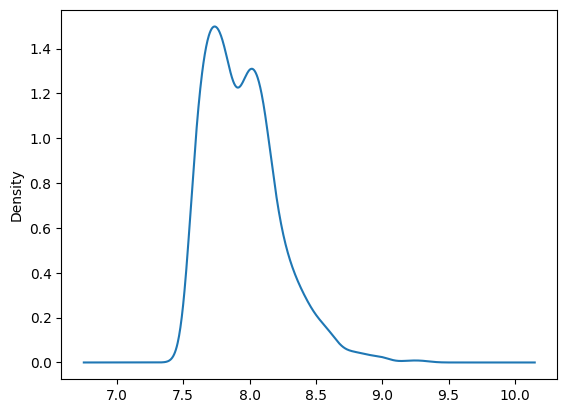

In [ ]:
#Optionally categorize data based on Imbd rating
df['IMDB_Rating'].plot(kind='kde')

In [ ]:
df.describe()

,IMDB_Rating,Meta_score,No_of_Votes
count,1000.000000,843.000000,1.000000e+03
mean,7.949300,77.971530,2.736929e+05
std,0.275491,12.376099,3.273727e+05
min,7.600000,28.000000,2.508800e+04
25%,7.700000,70.000000,5.552625e+04
50%,7.900000,79.000000,1.385485e+05
75%,8.100000,87.000000,3.741612e+05
max,9.300000,100.000000,2.343110e+06


In [ ]:
median = df['IMDB_Rating'].median()

In [ ]:
df['Category'] = df['IMDB_Rating'].apply(lambda x: "GOOD" if x > median else "BAD")

# Sample Prompt Interaction
```
{
  "messages": [
  {
    "role": "system",
    "content": "You are a movie critic binary classifer, that classifies a movie into two categories which are GOOD or BAD. You take following attributes as input from user MOVIE_NAME, MOVIE_DESCRIPTION, GENRE. You will output one of the two categories."
    },
  {
    "role": "user",
    "content": '''MOVIE_NAME: The Godfather MOVIE_DESCRIPTION: An organized crime dynasty's aging patriarch transfers control of his clandestine empire to his reluctant son. GENRE: Crime, Drama'''
    },
  {
    "role": "assistant",
    "content": "GOOD"
    }
  ]
}

```



In [ ]:
#Define Promp format
def create_prompt(row):
  user_content = "MOVIE_NAME: " + row['Movie_Title'] + ", MOVIE_DESCRIPTION: " + row['Overview'] + ", GENRE: " + row['Genre']
  assistant_response = row['Category']
  return {"messages": [{"role": "system", "content": "You are a movie critic binary classifier, that classifies a movie into two categories which are GOOD or BAD. You take following attributes as input from user MOVIE_NAME, MOVIE_DESCRIPTION, GENRE. You will output one of the two categories."},
 {"role": "user", "content": user_content},
  {"role": "assistant", "content": assistant_response}]}

In [ ]:
df['PROMPT'] = df.apply(create_prompt, axis=1)

In [ ]:
with open(prompt_data_path, 'w') as outfile:
    for entry in df['PROMPT']:
        json.dump(entry, outfile)
        outfile.write('\n')

In [ ]:
# Separate the data into GOOD and BAD categories
good_data = []
bad_data = []

for entry in df['PROMPT']:
    for message in entry['messages']:
        if message['role'] == 'assistant':
            if message['content'] == 'GOOD':
                good_data.append(entry)
            elif message['content'] == 'BAD':
                bad_data.append(entry)

# Calculate number of GOOD and BAD entries to put in each file
num_good_per_file = len(good_data) // 5
num_bad_per_file = len(bad_data) // 5

# Initialize counters and lists to store split data
good_count = 0
bad_count = 0
split_data = defaultdict(list)

# Distribute GOOD and BAD data equally across 5 files
for i in range(5):
    split_data[i] = good_data[good_count:good_count + num_good_per_file] + \
                    bad_data[bad_count:bad_count + num_bad_per_file]
    good_count += num_good_per_file
    bad_count += num_bad_per_file

# Write the data into 5 json files
for i, split in split_data.items():
    with open(f'movie_critic_fine_tuning_split{i+1}.jsonl', 'w') as f:
      #Shuffle the data
      random.shuffle(split)
      for line in split:
        json.dump(line, f)
        f.write('\n')

## Data preparation and analysis for chat model fine-tuning

In [ ]:
data_path = "movie_critic_fine_tuning_split4.jsonl"

# Load the dataset for train-test
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 199
First example:
{'role': 'system', 'content': 'You are a movie critic binary classifier, that classifies a movie into two categories which are GOOD or BAD. You take following attributes as input from user MOVIE_NAME, MOVIE_DESCRIPTION, GENRE. You will output one of the two categories.'}
{'role': 'user', 'content': "MOVIE_NAME: Where Eagles Dare, MOVIE_DESCRIPTION: Allied agents stage a daring raid on a castle where the Nazis are holding American brigadier general George Carnaby prisoner, but that's not all that's really going on., GENRE: Action, Adventure, War"}
{'role': 'assistant', 'content': 'BAD'}


In [ ]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue

    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue

    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1

        if any(k not in ("role", "content", "name", "function_call") for k in message):
            format_errors["message_unrecognized_key"] += 1

        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1

        content = message.get("content", None)
        function_call = message.get("function_call", None)

        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1

    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


In [ ]:
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [ ]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 4096 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 95, 145
mean / median: 114.36683417085428, 113.0
p5 / p95: 104.0, 127.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 1, 1
mean / median: 1.0, 1.0
p5 / p95: 1.0, 1.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning


In [ ]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~22759 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~68277 tokens


In [ ]:
# rough cost of API call
(n_epochs * n_billing_tokens_in_dataset / 1000) * 0.016

1.092432

In [ ]:
def train_test_split(data, train_percentage):
  if (train_percentage > 0.5 and train_percentage < 0.9):
    split_val = int(train_percentage * len(data))
  else:
    split_val = int(0.8 * len(data))
  return data[:split_val], data[split_val:]

# Split the dataset into train and test

In [ ]:
tr, ts = train_test_split(dataset, 0.8)

In [ ]:
print(f'Train size: {len(tr)}, Test size: {len(ts)}')

Train size: 159, Test size: 40


In [ ]:
with open('movie_critic_fine_tuning_test_split_4.jsonl', 'w') as outfile:
    for entry in ts:
        json.dump(entry, outfile)
        outfile.write('\n')

In [ ]:
with open('train_data_split_4.jsonl', 'w') as outfile:
    for entry in tr:
        json.dump(entry, outfile)
        outfile.write('\n')

# GPT-3.5 Turbo Baseline model

## Model Fine-tuning

## Fine-Tuning GPT-3.5 Turbo on 150 examples from Split 3

In [ ]:
data_to_train_path = "train_data_split_3.jsonl"
openai.File.create(
  file=open(data_to_train_path, "rb"),
  purpose='fine-tune'
)

In [ ]:
file_id = "<FILE_ID_FROM_PREVIOUS_STEP>"
model_name = "<MODEL_NAME>"

# Training on top of our previous fine-tuned model
openai.FineTuningJob.create(training_file=file_id, model=model_name, hyperparameters= {"n_epochs":3})

In [ ]:
job_id = "<JOB_ID_FROM_PREVIOUS_STEP>"

openai.FineTuningJob.retrieve(job_id)

## Run Predictions

In [ ]:
def run_gpt_model_predictions(model_name, data):
  pred_df = pd.DataFrame({}, columns=["User_Input", "Expected_Response_Content", "Expected_Response_Raw", "Model_Response_Raw", "Model_Response_Content"])
  print(pred_df)

  for idx, entry in enumerate(data):
    model_input = entry['messages'][:2]
    print("Message No: ", idx, ",  Message: ", entry['messages'][1])
    response = openai.ChatCompletion.create(
                                            model=model_name,
                                            messages=model_input,
                                            temperature=1,
                                            max_tokens=256,
                                            top_p=1,
                                            frequency_penalty=0,
                                            presence_penalty=0
                                          )
    pred_df.loc[idx] = [model_input, entry['messages'][2]['content'], entry['messages'][2], response, response['choices'][0]['message']['content']]
    time.sleep(5) # to not overload api requests, otherwise it will result in timeout error

  return pred_df


In [ ]:
# if you want to reproduce the same inference evaluation
# use the same dataset that I used for testing
with open('movie_critic_fine_tuning_split4.jsonl', 'r', encoding='utf-8') as f:
    ts = [json.loads(line) for line in f]

## Testing GPT-3.5 turbo straight out of box (no fine-tuning)

In [ ]:
output_df = run_gpt_model_predictions(model_name = "gpt-3.5-turbo", data = ts)
output_df.to_csv('gpt_baseline_data_test_split_4.csv')

## Testing 1st time fine-tuned model

In [ ]:
first_fine_tuned_model_name = "ft:gpt-3.5-turbo-0613:personal::8Ax6vzAF"
firstModelDF = run_gpt_model_predictions(model_name = first_fine_tuned_model_name, data = ts)
firstModelDF.to_csv('gpt_first_finetune_data_test_split_4.csv')

## Testing 2nd time fine-tuned model

In [ ]:
second_fine_tuned_model_name = "ft:gpt-3.5-turbo-0613:personal::8B4CgvKg"
secondModelDF = run_gpt_model_predictions(model_name = second_fine_tuned_model_name, data = ts)
secondModelDF.to_csv('gpt_second_finetune_data_test_split_4.csv')

## Testing 3rd time fine-tuned model

In [ ]:
third_fine_tuned_model_name = "ft:gpt-3.5-turbo-0613:personal::8B5I24Hi"
thirdModelDF = run_gpt_model_predictions(model_name = third_fine_tuned_model_name, data = ts)
thirdModelDF.to_csv('gpt_first_finetune_data_test_split_4.csv')

# Util Methods

In [ ]:
def convert_class_to_binary(positive_class, negative_class, input):
  if positive_class.lower() in input.lower():
    return 1
  elif negative_class.lower() in input.lower():
    return 0
  else:
    return -1

In [ ]:
def generate_report(filename):
  metric_list = []
  print("************************ " + filename + " ************************")
  tmp = pd.read_csv(filename, index_col=0)
  tmp['Expected_Binary'] = tmp['Expected_Response_Raw'].apply(lambda x: convert_class_to_binary("GOOD", "BAD", x))
  tmp['Response_Binary'] = tmp['Model_Response_Content'].apply(lambda x: convert_class_to_binary("GOOD", "BAD", x))
  sub_tmp = tmp[(tmp['Expected_Binary'] >= 0) & (tmp['Response_Binary'] >= 0)]

  cm = confusion_matrix(sub_tmp['Expected_Binary'], sub_tmp['Response_Binary'], labels=[1, 0])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["GOOD", "BAD"])
  disp.plot()
  disp.ax_.set_title(filename)

  print(classification_report(sub_tmp['Expected_Binary'], sub_tmp['Response_Binary'], labels=[1, 0]))

  print("************************************************")

  return classification_report(sub_tmp['Expected_Binary'], sub_tmp['Response_Binary'], labels=[1, 0], output_dict=True)

************************ gpt_baseline_data_test_split_4.csv ************************
              precision    recall  f1-score   support

           1       0.42      0.94      0.58        17
           0       0.50      0.04      0.08        23

    accuracy                           0.42        40
   macro avg       0.46      0.49      0.33        40
weighted avg       0.47      0.42      0.29        40

************************************************
************************ gpt_first_finetune_data_test_split_4.csv ************************
              precision    recall  f1-score   support

           1       0.80      0.24      0.36        17
           0       0.63      0.96      0.76        23

    accuracy                           0.65        40
   macro avg       0.71      0.60      0.56        40
weighted avg       0.70      0.65      0.59        40

************************************************
************************ gpt_second_finetune_data_test_split_4.csv *****

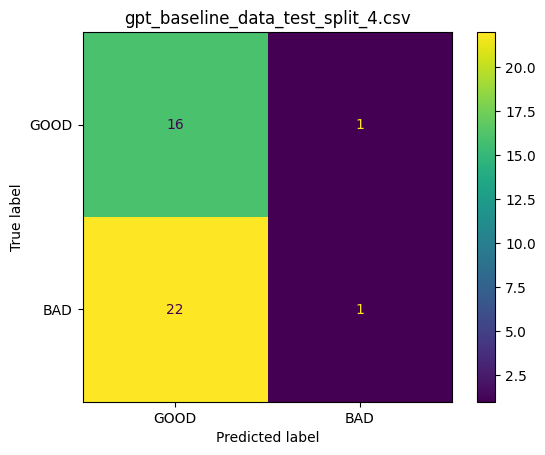

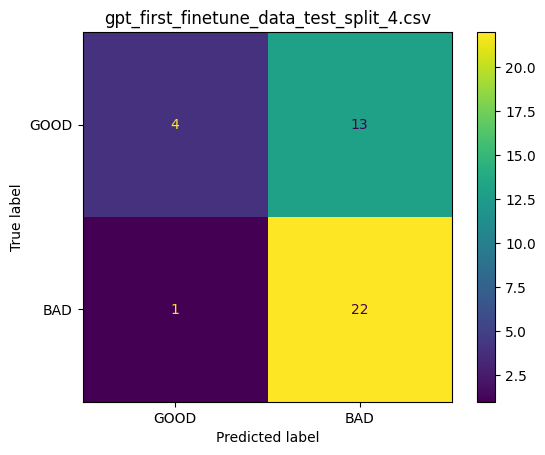

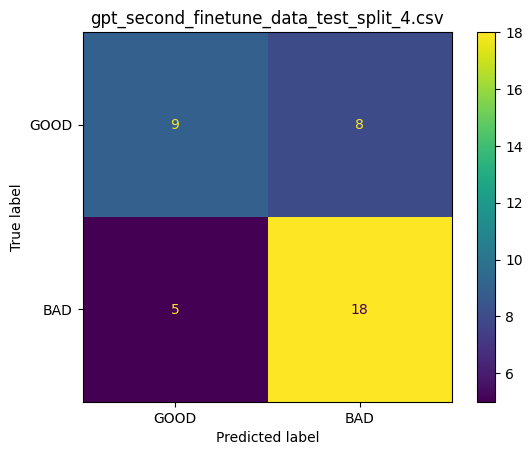

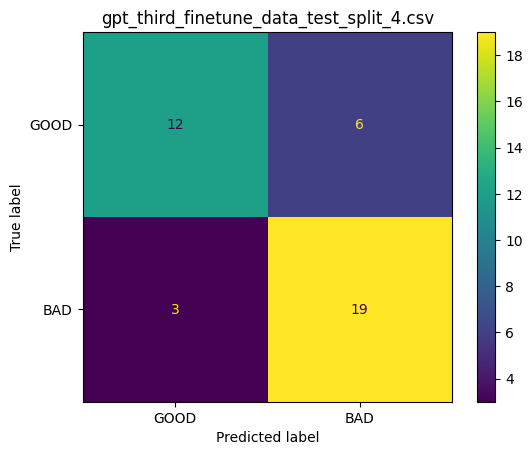

In [ ]:
metric_dict = dict()
# If you are not running the whole notebook
# Upload the files separately and provide their names in a list
for file_ in ["gpt_baseline_data_test_split_4.csv",
              "gpt_first_finetune_data_test_split_4.csv",
              "gpt_second_finetune_data_test_split_4.csv",
              "gpt_third_finetune_data_test_split_4.csv"]:
  metric_dict[file_.replace('.csv', '')] = generate_report(file_)

In [ ]:
accuracy_list = []
recall_list = []
precision_list = []
f1score_list = []
model_list = []
for k in metric_dict.keys():
  model_list.append(k.replace('_data_test_split_4', ''))
  accuracy_list.append(metric_dict[k]['accuracy'])
  recall_list.append(metric_dict[k]['weighted avg']['recall'])
  precision_list.append(metric_dict[k]['weighted avg']['precision'])
  f1score_list.append(metric_dict[k]['weighted avg']['f1-score'])


In [ ]:
metric_df = pd.DataFrame(
    {
        "Accuracy": accuracy_list,
        "Weighted Recall": recall_list,
        "Weighted Precision": precision_list,
        "Weighted F1-Score": f1score_list,
        "Model": model_list
    }
)

In [ ]:
metric_df

,Accuracy,Weighted Recall,Weighted Precision,Weighted F1-Score,Model
0,0.425,0.425,0.466447,0.293273,gpt_baseline
1,0.650,0.650,0.701429,0.590752,gpt_first_finetune
2,0.675,0.675,0.671291,0.669223,gpt_second_finetune
3,0.775,0.775,0.778000,0.771954,gpt_third_finetune


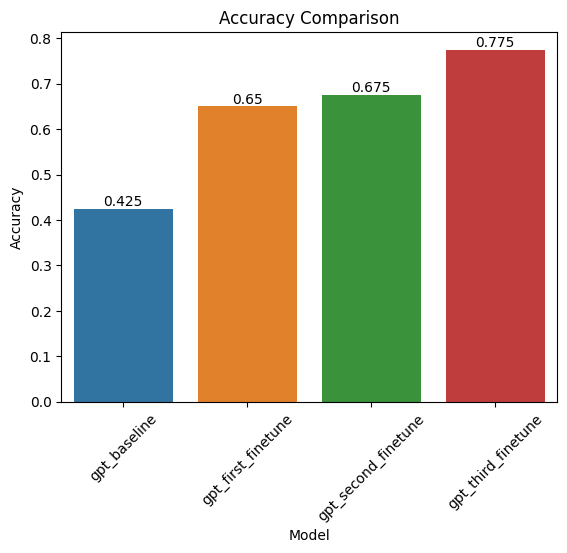

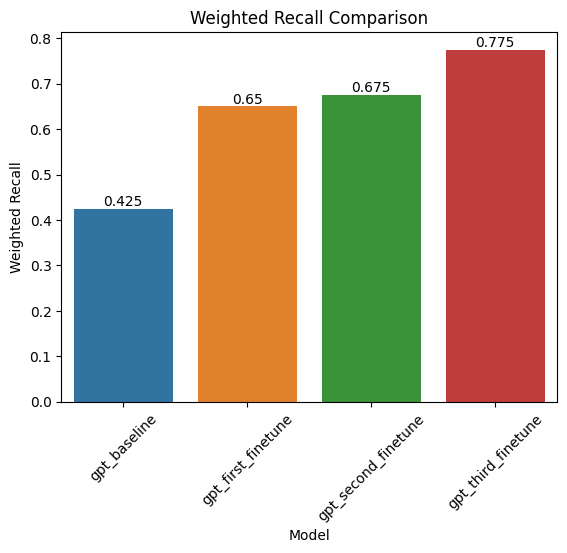

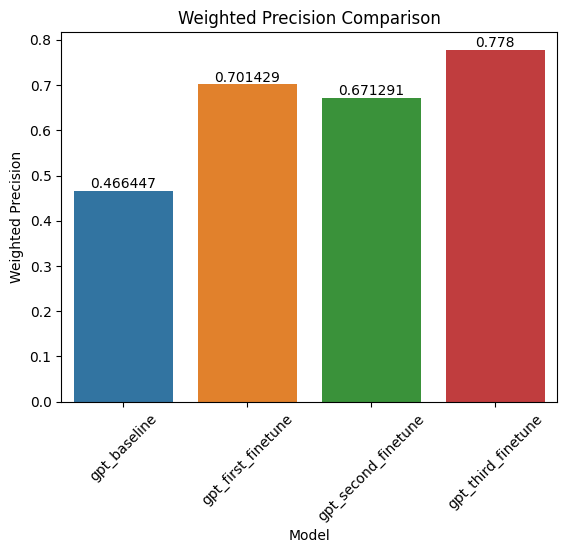

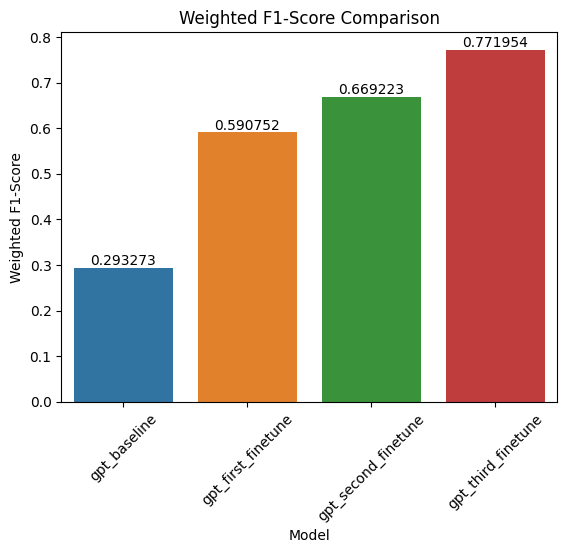

In [ ]:
for col in ["Accuracy", "Weighted Recall", "Weighted Precision", "Weighted F1-Score"]:
  ax = sns.barplot(metric_df, x="Model", y=col, estimator="sum", errorbar=None)
  ax.bar_label(ax.containers[0], fontsize=10);
  ax.set_title(col + " Comparison")
  plt.xticks(rotation=45)
  plt.show()